##### Written by Xin Qian (xinqian21@hust.edu.cn) at HUST.
This manuscript computes thermal conductivity using the Quantum Kubo Formalism. Thermal conductivity is calculated as:
\begin{equation}
\kappa_{\mu\nu} = \frac{1}{VT}\int_0^{1/k_BT}d\lambda\int_0^\infty \langle \hat{J}_\mu(t+i\hbar t)\hat{J}_\nu (0) \rangle dt
\end{equation}

The heat flux operators are calculated as:
\begin{equation}
\hat{J}_\mu(t) = \frac{i\hbar}{2}\sum_{m,n}v_{mn}^\mu\omega_n[\hat{a}^+_m + \hat{a}_m(t)][\hat{a}^+_n - \hat{a}_n(t)]
\end{equation}

By doing operator algebra, the thermal conductivity is calculated as:
\begin{equation}
\kappa_{\mu\nu} = \sum_{m,n} C_{mn}v^\mu_{mn}v^\nu_{nm}\tau_{mn}
\end{equation}

The generalized specific heat, velocity and co-relaxation time for phonon pairs are expressed as:
\begin{equation}
C_{mn} = \frac{\hbar\omega_m\omega_n}{VT}\frac{N_m-N_n}{\omega_m-\omega_n}
\end{equation}
\begin{equation}
\textbf{v}_{mn} = \frac{i\delta(\textbf{q}_m-\textbf{q}_n)}{\sqrt{\omega_m\omega_n}}\langle m \left| \nabla_{\textbf{q}} \textbf{D} \right|n\rangle
\end{equation}
\begin{equation}
\tau_{mn} = \frac{\gamma_m+\gamma_n}{(\omega_m-\omega_n)^2+(\gamma_m+\gamma_n)^2}
\end{equation}

The Kubo formalism is orginally derived by Isaeva [Nat. Commun. 10, 3853 (2019)].
If you use API Phonons for such calculation, please cite [Mater. Today Phys. 50, 101630 (2025)].

In [1]:
import matplotlib
import numpy as np

import API_phonopy as api_ph
import API_phonopy_lammps as api_pl
import phonopy
from phonopy import Phonopy

from phonopy.interface.calculator import get_default_physical_units
from phonopy.file_IO import get_born_parameters

import Kappa_Kubo as Kubo
from hiphive import ForceConstants
import API_thirdorder as FC3
import matplotlib.pyplot as plt

In [2]:
T = 300 # set temperature

NAC = False # non-analytical calculations
Nrepeat=[2,1,2] # supercell matrix used for FC2
mesh = [7,5,8] # q-mesh, should be consistent with ShengBTE setting.

# Specify the directory and the filenames of POSCAR, phonon lifetimes, and harmonic FCs.

POSCAR_FILE = 'POSCAR' # unit cell structure file for vasp
SCATTRATE_FILE = './' + 'T'+ str(T) +'K' +'/BTE.w' # file from ShengBTE for scattering rate.
FC2_FILE = 'FORCE_CONSTANTS_2ND'

In [3]:
# read fc2 and convert format for phono3py calculations.
phonon = phonopy.load(supercell_matrix=Nrepeat,unitcell_filename=POSCAR_FILE, 
                      force_constants_filename= FC2_FILE)
# create a phonopy object and read the POSCAR, FC2 files. 
if NAC == True:
    nac_params = get_born_parameters(open("BORN"),phonon.primitive,phonon.primitive_symmetry)
    if nac_params['factor'] == None:
        physical_units = get_default_physical_units(interface_mode)
        nac_params['factor'] = physical_units['nac_factor']
    phonon._nac_params=nac_params

phonon.symmetrize_force_constants()
phonon.run_mesh(mesh,is_gamma_center=True,with_eigenvectors=True,with_group_velocities=True)
# calculate eigen-frequencies and eigenvectors using Gamma centered mesh. 

In [4]:
freqs = phonon.get_mesh_dict()['frequencies']
weights = phonon.get_mesh_dict()['weights']
qpoints = phonon.get_mesh_dict()['qpoints'] # irreducible wedge

scatt_rate_ph = Kubo.read_ShengBTE_scattRate(SCATTRATE_FILE,phonon)
scatt_rate_ph[np.isinf(scatt_rate_ph)] = 0

In [5]:
Kappa_Kubo,Kappa_Ph,Kxx_mp,Kyy_mp,Kzz_mp,freqs = Kubo.calc_QHGK_ShengBTE_at_T(phonon,mesh,scatt_rate_ph,T)

/home/xinqian/Softwares/API_Phonons/Kappa_Kubo.py:44: RuntimeWarning: divide by zero encountered in true_divide
  Tau_sr = 1/Scatt_Rate + Tau_sr_offdiag


In [6]:
# Thermal conductivity tensor is arranged as xx, yy, zz, xy, yz, zx.
print('QHGK kappa = ')
print(Kappa_Kubo)
print('Phonon RTA kappa = ')
print(Kappa_Ph)

QHGK kappa = 
[0.36357374 0.3551763  0.34520434 0.0016887  0.00933007 0.05216113]
Phonon RTA kappa = 
[0.16177764 0.16807307 0.15956284 0.00133272 0.00516981 0.03518778]


In [7]:
# Flatten the kappa matrix. 

Nq,Nbrch = Kxx_mp.shape[:2]

Kxx_mp_flat = np.zeros((Nq*Nbrch,Nq*Nbrch))
Freqs_flat = np.zeros(Nq*Nbrch)

for iq in range(Nq):
    Freqs_flat[iq*Nbrch:(iq+1)*Nbrch] = freqs[iq]
    Kxx_mp_flat[iq*Nbrch:(iq+1)*Nbrch,iq*Nbrch:(iq+1)*Nbrch] = Kxx_mp[iq]

Wm,Wn = np.meshgrid(Freqs_flat,Freqs_flat)

Kxx = Kappa_Kubo[0]

Kappa_mat_frac = Kxx_mp_flat/Kxx
gtzero = Kappa_mat_frac>np.mean(Kappa_mat_frac)*0.001

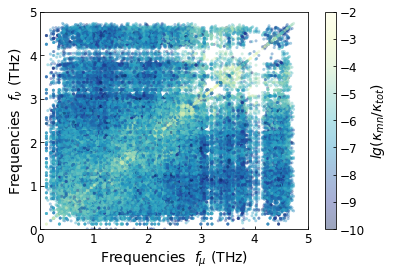

In [8]:
tick_fontsize = 12
label_fontsize = 14
plt.scatter(Wm[gtzero],Wn[gtzero],c=np.log10(Kappa_mat_frac[gtzero]),marker='.',edgecolors='none',cmap='YlGnBu_r',alpha=0.4)
cbar = plt.colorbar()
cbar.set_label('$lg(\kappa_{mn}/\kappa_{tot})$',fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize, direction='in')

plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in')


plt.clim([-10,-2])
plt.xlim([0,5])
plt.ylim([0,5])
plt.xlabel('Frequencies  $f_\mu$ (THz)',fontsize = label_fontsize)
plt.ylabel('Frequencies  $f_ν$ (THz)',fontsize = label_fontsize)
plt.savefig("kappa_matrix_T" +str(T)+ "K.jpg",dpi=600,bbox_inches='tight')